In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16 #16
cpus_per_task = 2 #2
omp_num_threads = 2 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

In [3]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00', #memory='120GB',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# GW convergence analysis for AGSLn with n=6

We perform a convergence study for the GW runlevel

## HF Analysis

We do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters as

* RandGVec = 100
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 8x24x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__We choose to apply the cutoff on both the EXXRLvcs and the VXCRLvcs variables, since they are subtracted for the computation of the GW correction. This approach differs for the one adopted in the n_5 case in which the VXCRLvcs has been left to its DFT value.__
__Anyway the numerical difference should be negligible.__

In [4]:
input_dir = 'DFT_analysis/kpoints_8x24-nbnds_50.save'
run_dir = 'MB_analysis/kpoints_8x24-nbnds_50'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_8x24-nbnds_50/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [6]:
start_band,stop_band = 49,50 # bands range for the computation of the HF corrections
Gamma_index = 1
RandGvec = 100
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
#inp

We perform a convergence run on the EXXRLvcs parameter

In [7]:
study = D.Dataset(run_dir=run_dir,num_tasks=5,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.,60.,70.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname=idd)

Initialize a Dataset with 5 parallel tasks


In [8]:
#study.runs[2]

In [9]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6] with the parallel task_groups [[0, 1, 2, 3, 4], [5, 6]] 

Run the task [0, 1, 2, 3, 4] 
Skip the run ofSkip the run of  Skip the run ofhf-G-exxrlvcs_20.0hf-G-exxrlvcs_30.0 

hf-G-exxrlvcs_40.0
Skip the run of hf-G-exxrlvcs_50.0
Skip the run of hf-G-exxrlvcs_10.0
Task [0, 1, 2, 3, 4] ended 
 
Run the task [5, 6] 
Skip the run of hf-G-exxrlvcs_60.0
Skip the run of hf-G-exxrlvcs_70.0
Task [5, 6] ended 
 


We plot the values of the gap at the $\Gamma$ point

In [10]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(EXXRLvcs))]
gap_G

[1.142594,
 1.142376,
 1.1426720000000001,
 1.1426429999999999,
 1.142878,
 1.1430660000000001,
 1.1430490000000002]

Text(0.5, 0, 'EXXRLvcs (Ha)')

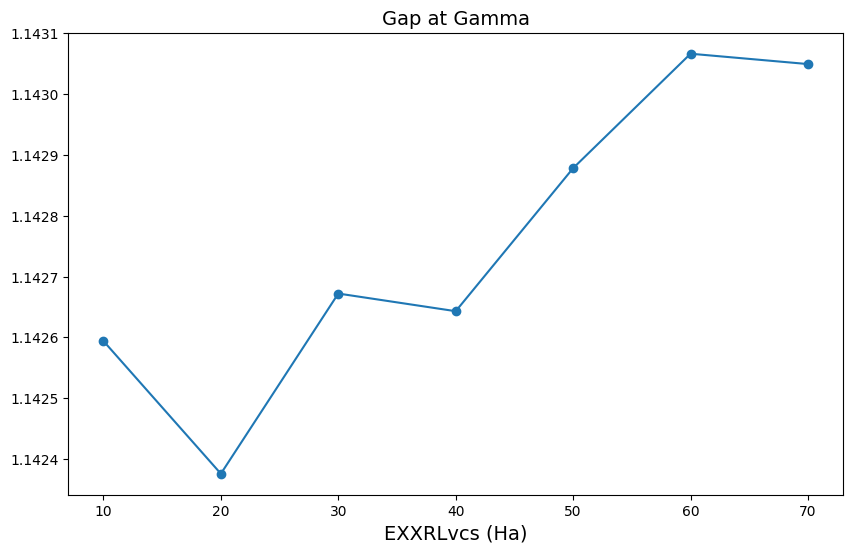

In [11]:
fig, axes = plt.subplots(figsize=(10, 6))
axes.plot(EXXRLvcs,gap_G)
axes.scatter(EXXRLvcs,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('EXXRLvcs (Ha)',size=14)

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 50 Ha

which guarantees the convergence of the HF gap at $\Gamma$ at the level of 1 meV.

## HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $\Gamma$ in function of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [4]:
start_band,stop_band = 49,50 # bands range for the computation of the HF corrections
Gamma_index = 1
RandGvec = 100
RandQpts = 5e6

EXXRLvcs = 50. # Ha
EXXRLVcs_units = 'Ha'

In [5]:
kvalues = [5,8,12,15,20]

In [7]:
study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    input_dir = 'DFT_analysis/kpoints_%sx%s-nbnds_50.save'%(k,3*k)
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_50'%(k,3*k)
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='OMP_NUM_THREADS=1 mpirun -np 1 p2y',yambo_command='OMP_NUM_THREADS=1 mpirun -np 1 yambo')
    
    inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 1 nodes on ismhpc (with 16 mpi and 2 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%sx%s'%(k,3*k)
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 4 parallel tasks
SAVE folder MB_analysis/kpoints_5x15-nbnds_50/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_8x24-nbnds_50/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_12x36-nbnds_50/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_15x45-nbnds_50/SAVE already present. No operations performed.
Create the folder path MB_analysis/kpoints_20x60-nbnds_50
Executing command: cd MB_analysis/kpoints_20x60-nbnds_50; OMP_NUM_THREADS=1 mpirun -np 1 p2y -I ../../DFT_analysis/kpoints_20x60-nbnds_50.save
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
Build the r_setup in the yambo_dir path MB_analysis/kpoints_20x60-nbnds_50


In [9]:
study.ids

['hf-G-kpoints_5x15',
 'hf-G-kpoints_8x24',
 'hf-G-kpoints_12x36',
 'hf-G-kpoints_15x45',
 'hf-G-kpoints_20x60']

In [10]:
#study.runs[3]

In [11]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1, 2, 3], [4]] 

Run the task [0, 1, 2, 3] 
Skip the run of hf-G-kpoints_15x45
Skip the run of hf-G-kpoints_12x36
Skip the run of hf-G-kpoints_5x15
Skip the run of hf-G-kpoints_8x24
Task [0, 1, 2, 3] ended 
 
Run the task [4] 
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F hf-G-kpoints_20x60.in -J hf-G-kpoints_20x60 -C hf-G-kpoints_20x60
slurm submit:  cd MB_analysis/kpoints_20x60-nbnds_50 ; sbatch job_hf-G-kpoints_20x60.sh
computation hf-G-kpoints_20x60 is running...
computation hf-G-kpoints_20x60 ended
Run performed in 18m-48s
Task [4] ended 
 


In [12]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(kvalues))]
gap_G

[1.3782969999999999,
 1.142878,
 1.0109740000000003,
 0.9614499999999999,
 0.9169970000000001]

Text(0.5, 0, 'k-sampling')

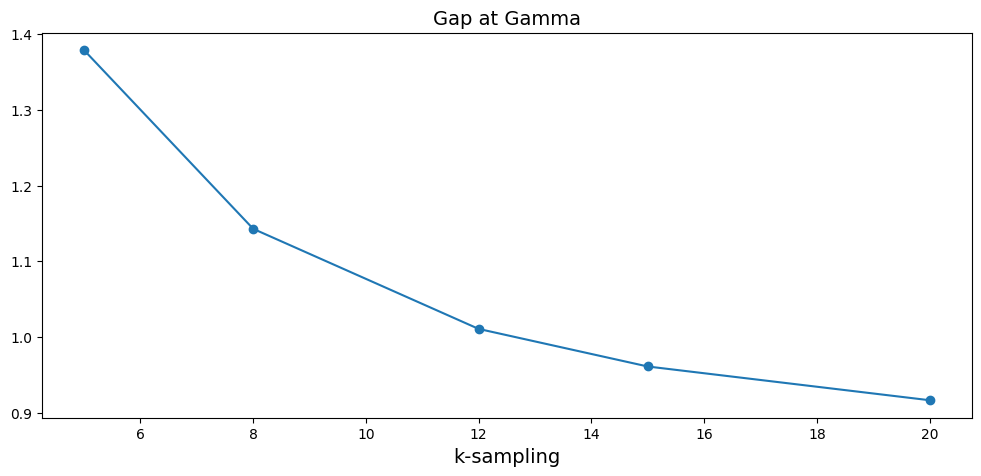

In [13]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.plot(kvalues,gap_G)
axes.scatter(kvalues,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('k-sampling',size=14)
#axes.hlines(gap_G[-1],10.,30,linestyles='-',color='gray',linewidth=1)
#axes.hlines(gap_G[-1]+0.005,10.,30,linestyles='-',color='gray',linewidth=1)
#axes.axhspan(gap_G[-1], gap_G[-1]+0.005, xmin = 0.2,facecolor='red', alpha=0.5)

The convergence of the exchange part of the gap is quite slow, howevere the convergence rate is improved when also the correlation contribution is considered (see below). So the evaluation of the convergend k-points sampling is performed for the complete GW gap.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ using the plasmon pole run level.

In [3]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr,clean_restart=False)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': False,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

### Convergence analysis of the screening

#### Convergence of the NGsBlkXp parameter

We use the 8x24x1 k-points sampling and perform a convergence analysis in the BndsRnXp and GbndRnge parameters needed to compute the screening function.

We perform this analysis using the RIM_W with RandGvecW=10.

__The variable LongDrXp is set to the inplane value [1,1,0]__ 

In [5]:
input_dir = 'DFT_analysis/kpoints_8x24-nbnds_800.save'
run_dir = 'MB_analysis/kpoints_8x24-nbnds_800'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,yambo_command='OMP_NUM_THREADS=1 yambo')

SAVE folder MB_analysis/kpoints_8x24-nbnds_800/SAVE already present. No operations performed.


We the define the input variables common to all the runs

In [8]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 49,50
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 50. # Ha

LongDrXp=[1.,1.,0.] 

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs) 
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

8 2


First we run over NGsBlkXp and we set the number of bands in the response function to the 400 for a balance between computational time and a proper
check of the convergence of the G size of the response (since these variables are correlated).

In [25]:
NGsBlkXp = [4.0,6.0,8.0] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,400] # Bands in the response function
GbndRnge = [1,400]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs'],reformat=False)

Initialize a Dataset with 4 parallel tasks


In [26]:
study.ids

['pp-G-ngsblkxp_4.0-bndsrnxp_400-gbndrnge_400',
 'pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400',
 'pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400']

In [27]:
#study.runs[0]

In [29]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400
Skip the run of pp-G-ngsblkxp_4.0-bndsrnxp_400-gbndrnge_400
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400
Task [0, 1, 2] ended 
 


In [30]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(NGsBlkXp))]
gap_G

[0.28467699999999996, 0.28846499999999997, 0.28894600000000004]

In [25]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(NGsBlkXp))]
gap_G

[0.3090160000000002, 0.30586899999999995, 0.3055920000000001]

Text(0.5, 0, 'NGsBlkXp (Ha)')

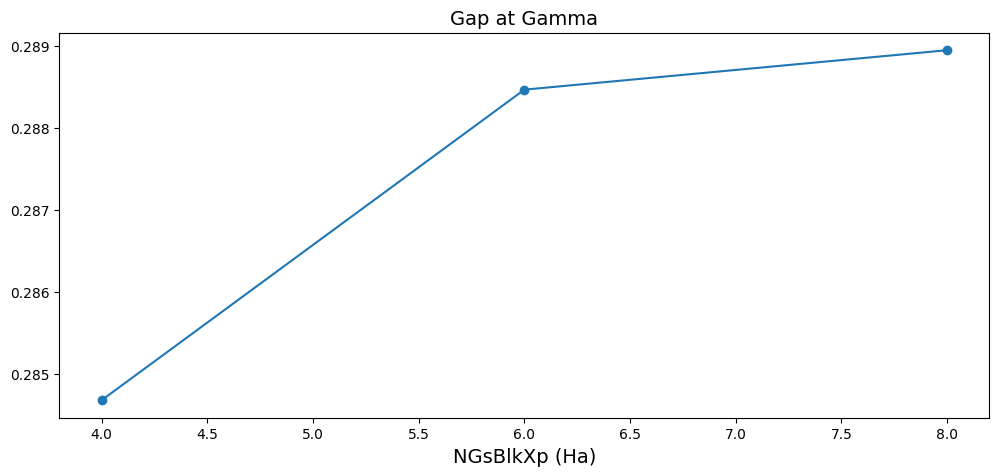

In [31]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.plot(NGsBlkXp,gap_G)
axes.scatter(NGsBlkXp,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('NGsBlkXp (Ha)',size=14)

We observe that the choice NGsBlkXp = 6 Ha should could provide convergence of the screening at the level of few meV,
also in view of a possible hidden slower convergence rate due to the correlation between this value and the number of bands.

#### Convergence of the BndsRnXp parameter

We perform a convergence analysis on the number of bands of the screening.For this analysis the
number of bands of the Green function is keep fixed at the value GbndRnge = 400

In [45]:
ntasks_c = 8 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 49,50
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 50. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands  = [[1,300],[1,400],[1,500],[1,600]] # Bands in the response function
GbndRnge = [1,400]  # Bands in the Sigma_c
LongDrXp=[1.,1.,0.] 

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(BndsRnXp=bands)
    inp.set_array_variables(GbndRnge=GbndRnge)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs'],reformat=False)

8 2
Initialize a Dataset with 4 parallel tasks


In [46]:
study.ids

['pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_400',
 'pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_400',
 'pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_400']

In [47]:
#study.runs[0]

In [48]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1, 2, 3]] 

Run the task [0, 1, 2, 3] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_400
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_400
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_400
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400
Task [0, 1, 2, 3] ended 
 


In [49]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(Bands))]
gap_G

[0.288879, 0.28846499999999997, 0.288676, 0.289187]

Text(0.5, 0, 'BndsRnXp')

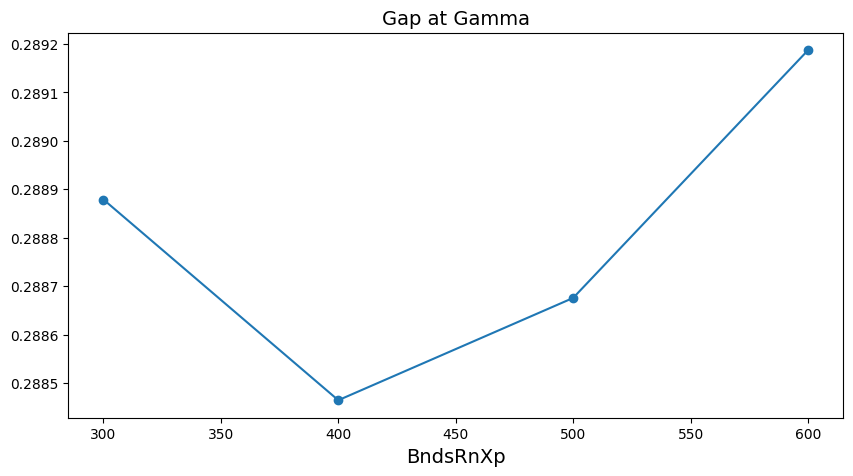

In [50]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(x_vals,gap_G)
axes.scatter(x_vals,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('BndsRnXp',size=14)

We observe that 400 bands in the screening provide an acceptable convergence. We choose to increase this
value to 500 for safety, since in this procedure we are only checking the convergence rate at $\Gamma$.

#### Convergence of the GbndRnge parameter

We perform a convergence analysis on the number of bands of the G function. We also test the effects of the terminator on the G function.

In [10]:
ntasks_c = 8 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 49,50
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 50. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,500]
LongDrXp=[1.,1.,0.] 
Bands  = [[1,300],[1,400],[1,500],[1,700],[1,800]] # Bands in the G function #,[1,600]

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp)

study = D.Dataset(num_tasks=6,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndbs-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)

inp.set_scalar_variables(GTermKind='BG')

for bands in Bands:
    inp.set_array_variables(GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndbs-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)


8 2
Initialize a Dataset with 6 parallel tasks


In [11]:
study.ids

['pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_300',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_400',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_700',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_800',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_300-Gterm',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_400-Gterm',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-Gterm',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_700-Gterm',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_800-Gterm']

In [12]:
#study.runs[5]

In [13]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3, 4, 5], [6, 7, 8, 9]] 

Run the task [0, 1, 2, 3, 4, 5] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_700Skip the run of
 pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_800
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_300
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_400
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_300-Gterm
Task [0, 1, 2, 3, 4, 5] ended 
 
Run the task [6, 7, 8, 9] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_700-Gterm
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_800-Gterm
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_400-Gterm
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-Gterm
Task [6, 7, 8, 9] ended 
 


In [14]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(Bands))]
gap_G_Gterm = [results[ind+len(Bands)].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(Bands))]

gap_G,gap_G_Gterm

([0.283517, 0.288676, 0.29207500000000003, 0.295159, 0.296865],
 [0.30132000000000003, 0.302191, 0.302679, 0.30286900000000005, 0.303087])

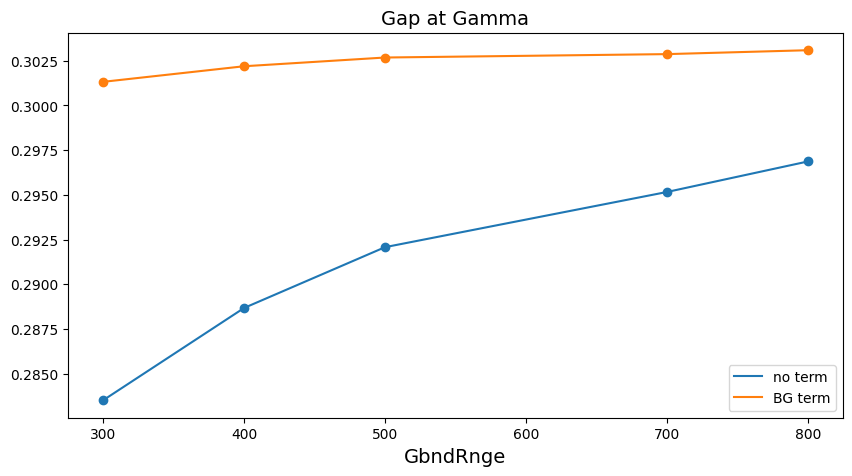

In [15]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(x_vals,gap_G,label='no term')
axes.scatter(x_vals,gap_G)
axes.plot(x_vals,gap_G_Gterm,label='BG term')
axes.scatter(x_vals,gap_G_Gterm)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('GbndRnge',size=14)
axes.legend()

On the basis of this analysis we conclude that the optimal parameters for the convergence of the screening are

NGsBlkXp = 6.0 # Ha G size of the response function
BndsRnXp = [1,500]
GbndRnge = [1,500] with BG terminator

### Convergence analysis of the k-points sampling

We test the effect of the k-points sampling on the GW correction ast the pp level.

In [109]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr) #,clean_restart=False
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [110]:
ksamplings = {'5x15': {'folder':'kpoints_5x15-nbnds_600','npoints':24},
             '8x24': {'folder':'kpoints_8x24-nbnds_800','npoints':65},
             '12x36': {'folder':'kpoints_12x36-nbnds_600','npoints':133},
            }

In [111]:
for k in ksamplings:
    input_dir=os.path.join('DFT_analysis',ksamplings[k]['folder']+'.save')
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='OMP_NUM_THREADS=1 mpirun -np 1 p2y',yambo_command='OMP_NUM_THREADS=1 mpirun -np 1 yambo')

SAVE folder MB_analysis/kpoints_5x15-nbnds_600/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_8x24-nbnds_800/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_12x36-nbnds_600/SAVE already present. No operations performed.


In [112]:
ntasks_c = 8 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 49,50
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 50. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,500]
GbndRnge  = [1,500] # Bands in the G function
LongDrXp=[1.,1.,0.] 

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_array_variables(LongDrXp=LongDrXp)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
    #inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.4') # for 1 nodes on leonardo
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(GTermKind='BG')
    # append run at G
    idd = 'pp-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndbs-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)


8 2
Initialize a Dataset with 4 parallel tasks


In [113]:
study.ids

['pp-G-kpoints_5x15', 'pp-G-kpoints_8x24', 'pp-G-kpoints_12x36']

In [114]:
#study.runs[0]

In [115]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run ofSkip the run of  pp-G-kpoints_8x24pp-G-kpoints_5x15

Skip the run of pp-G-kpoints_12x36
Task [0, 1, 2] ended 
 


In [76]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(ksamplings.keys()))]
gap_G

[0.253946, 0.302679, 0.321425]

In [117]:
x_vals = [ksamplings[k]['npoints'] for k in ksamplings]
labels = [k for k in ksamplings]
x_vals

[24, 65, 133]

In [118]:
labels

['5x15', '8x24', '12x36']

Text(0.5, 0, 'number of kpoints')

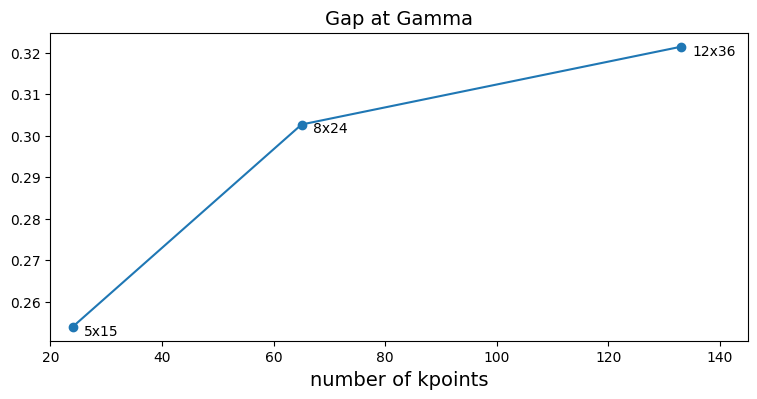

In [129]:
fig, axes = plt.subplots(figsize=(9, 4))
axes.plot(x_vals,gap_G)
axes.scatter(x_vals,gap_G)
for ind in range(len(ksamplings)):
    axes.text(x_vals[ind]+2,gap_G[ind]-0.002,labels[ind])
axes.set_xlim(20,145)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('number of kpoints',size=14)

The best estimate of the gap at $\Gamma$ with the actual k-points sampling is of 321 meV. The estimated error is of the order of 10 meV.

### Quasi-particle band structure

We use the convergence test performed above to computed the GW correction in the whole BZ. In this way we can compute the quasi-particle correction of the band structure.


In [79]:
# RunRules for leonardo
nodes = 8
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [80]:
ksamplings = {'5x15': {'folder':'kpoints_5x15-nbnds_600','npoints':24},
             '8x24': {'folder':'kpoints_8x24-nbnds_800','npoints':65},
             '12x36': {'folder':'kpoints_12x36-nbnds_600','npoints':133},
            }

In [88]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 48,51
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6
LongDrXp=[1.,1.,0.] 

kpoints = '12x36'

EXXRLVcs_units = 'Ha'
EXXRLvcs = 50. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,500]
GbndRnge  = [1,500] # Bands in the G function

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(LongDrXp=LongDrXp)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.2.16') # for 8 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(GTermKind='BG')
# append run for the QP correction in the whole BZ
idd = 'pp-allBZ-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,'pp-G-kpoints_%s'%kpoints],reformat=False)

16 2
Initialize a Dataset with 1 parallel tasks


In [89]:
study.ids

['pp-allBZ-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-Gterm']

In [90]:
#study.runs[0]

In [91]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of pp-allBZ-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-Gterm
Task [0] ended 
 


#### Ypp Analysis

We compute the GW correction along a hygh-simmetry path by interpolating the result of the BZ grid 

In [100]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr,executable='ypp')
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [101]:
ndbQP = 'pp-allBZ-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-Gterm/ndb.QP'

In [102]:
kpoints = '12x36'
run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
start_band,stop_band = 48,51
bands_step = 50

# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]
high_sym = {'G':G_cryst,'K':K_cryst,'M':M_cryst,'M2':M2_cryst} # useful to label the high-sym point on the path
path = [G_cryst,M2_cryst,K_cryst,M_cryst,G_cryst,K_cryst]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

#inp = I.YamboInput(args='ypp -e s',folder=run_dir,filename='ypp.in')
inp = I.YamboInput(folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=[start_band,stop_band],BANDS_steps=bands_step,BANDS_kpts=path)
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

idd = 'ypp_bands_dft'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [30,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [30,'']
study.append_run(id=idd,input=inp,runner=code) 

idd = 'ypp_bands_gw'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [30,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [30,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 2 parallel tasks


In [103]:
study.ids

['ypp_bands_dft', 'ypp_bands_gw']

In [104]:
study.runs[1]

{'label': 'Dataset',
 'run_dir': 'MB_analysis/kpoints_12x36-nbnds_600',
 'num_tasks': 2,
 'verbose': True,
 'input': {'args': '',
  'folder': 'MB_analysis/kpoints_12x36-nbnds_600',
  'filename': 'ypp.in',
  'arguments': ['electrons', 'bnds'],
  'variables': {'INTERP_Shell_Fac': [30, ''],
   'INTERP_NofNN': [1.0, ''],
   'OutputAlat': [0.0, ''],
   'BANDS_steps': [50, ''],
   'PROJECT_mode': 'none',
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'CIRCUIT_E_DB_path': 'none',
   'BANDS_bands': [[48, 51], ''],
   'BANDS_kpts': [[[0.0, 0.0, 0.0],
     [0.0, 0.5, 0.0],
     [0.5, 0.5, 0.0],
     [0.5, 0.0, 0.0],
     [0.0, 0.0, 0.0],
     [0.5, 0.5, 0.0]],
    ''],
   'GfnQP_DbGd_INTERP_mode': 'BOLTZ',
   'GfnQP_INTERP_shells': [30, ''],
   'GfnQPdb': 'E < pp-allBZ-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-Gterm/ndb.QP'}},
 'name': 'ypp_bands_gw'}

In [ ]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core ypp -F ypp_bands_dft.in -J ypp_bands_dft -C ypp_bands_dft
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core ypp -F ypp_bands_gw.in -J ypp_bands_gw -C ypp_bands_gw
slurm submit:  cd MB_analysis/kpoints_12x36-nbnds_600 ; sbatch job_ypp_bands_dft.shslurm submit: 
 cd MB_analysis/kpoints_12x36-nbnds_600 ; sbatch job_ypp_bands_gw.sh
computation ypp_bands_dft is running...
computation ypp_bands_gw is running...


In [106]:
bands_gw = U.BandStructure.from_Ypp(results[1],high_sym,suffix='bands_interpolated')
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

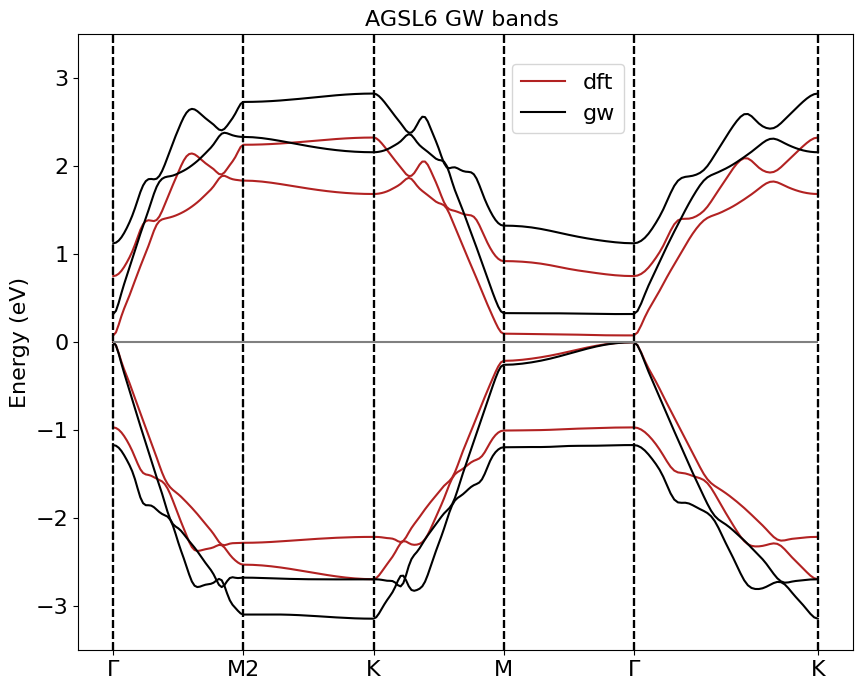

In [108]:
fig, ax1 = plt.subplots(figsize=(10,8))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='-',label='dft',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='gw',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='black')
ax1.hlines(0.,0.,2.707,linestyles='-',color='gray')
ax1.set_ylim(-3.5,3.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('AGSL6 GW bands ',size=16)
ax1.legend(loc=(0.56,0.84),fontsize=16,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)